<h1>Introdução</h1>
O objetivo deste trabalho é integrar dados das <b>Unidades de Conservação</b>, disponibilizados pelo <b>Ministério do Meio Ambiente e Mudança do Clima</b>, com dados de <b>incremento de desmatamento por bioma e município</b>, fornecidos pelo <b>Instituto Nacional de Pesquisas Espaciais</b>, a fim de facilitar as análises sobre a efetividade das Unidades de Conservação no controle do desmatamento


<h3>Observações Iniciais</h3>

<ul>
  <li>Considera-se como desmatamento a supressão da vegetação nativa, independentemente da futura utilização dessas áreas.</li>
  <li>Os dados referentes ao incremento de desmatamento por bioma e município foram obtidos da plataforma <b>TerraBrasilis</b> (INPE), a partir de um painel interativo de incremento anual de desmatamento por bioma, embora os dados originais tenham sido gerados por meio da interpretação de imagens de satélias.</li>
  <li>Em 2019, o IBGE lançou o <b>Mapa de Biomas e Sistema Costeiro-Marinho do Brasil</b>, na escala 1:250.000, com um detalhamento vinte vezes maior que o da edição anterior, publicada em 2004.</li>
</ul>


<h1>Diagrama Dados</h1>

In [1]:
from IPython.display import SVG, display

<b>Diagrama UML dos Dados de Incremento de Desmatamneto</b>

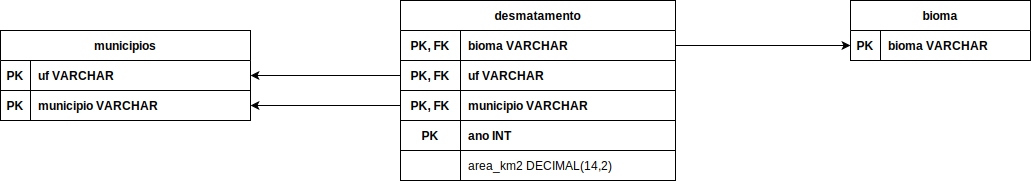

In [2]:
display(SVG(filename="digDesmatamento.svg"))


<b>Diagrama UML dos Dados de Unidades de Conservação</b><br>
Na organização original deste conjunto de dados, todos os atributos aparentam estana mesmaa tabela, o que podriae gerar anomalias de inserção e atualização. O diagrama abaixo foi adaptado em relação ao original, com o objetivo de melhorar a consistência dos dados


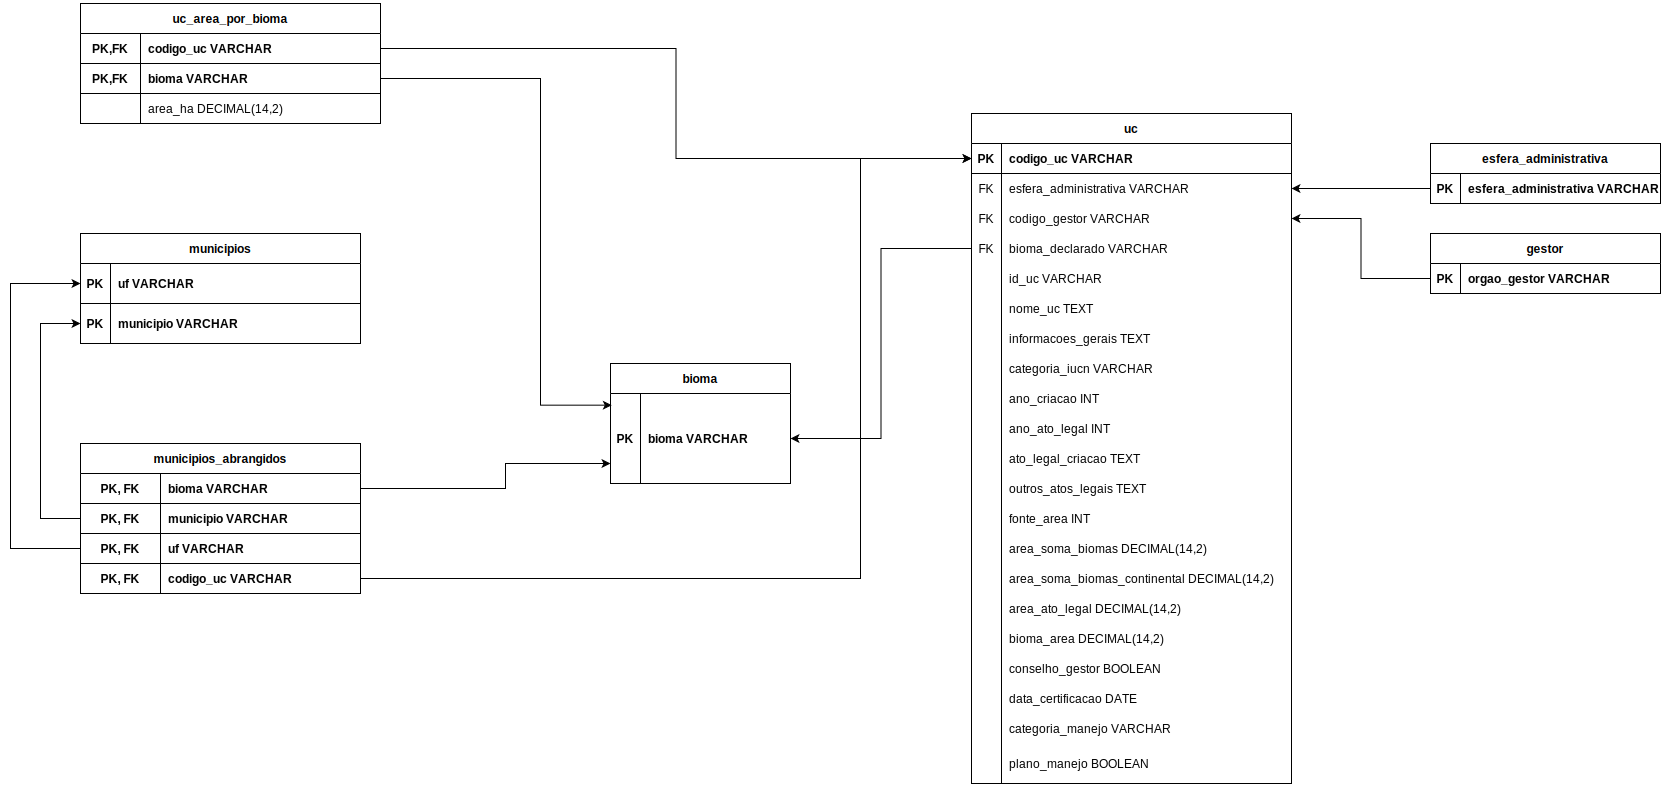

In [3]:
display(SVG(filename="digUC.svg"))


<b>Diagrama Intersecção Conjunto de Dados</b>

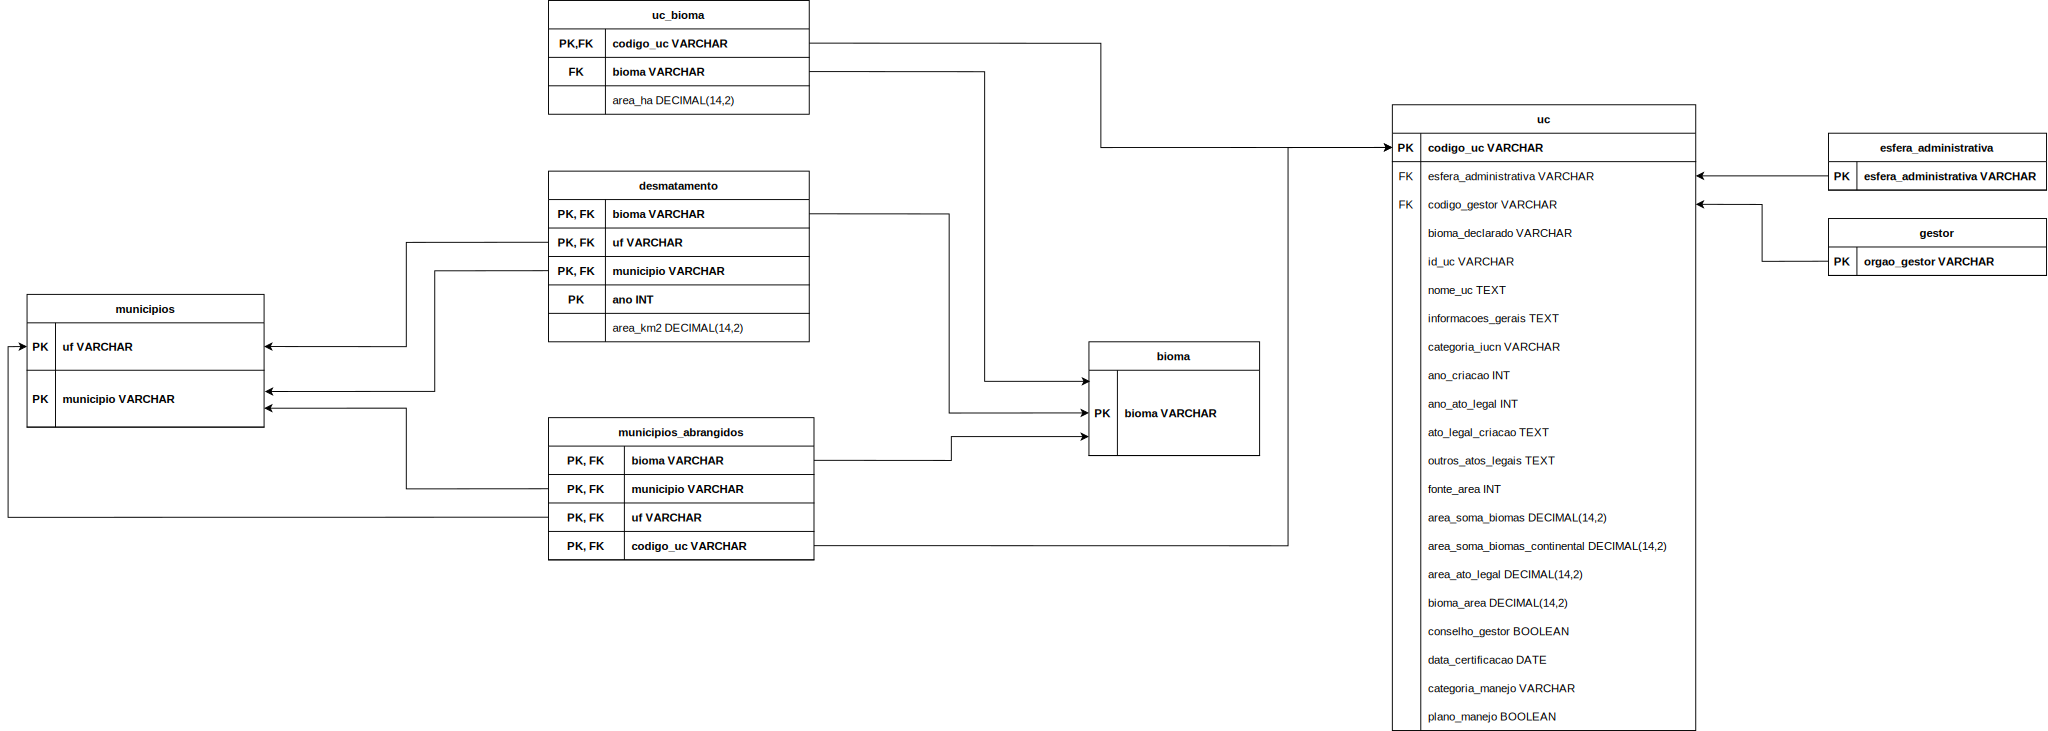

In [4]:
display(SVG(filename="digUniao.svg"))


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
cnuc = pd.read_csv('cnuc_2025_03.csv', sep=';', decimal=",", encoding='utf-8')
d_amazonia = pd.read_csv('terrabrasilis_amazon_09_06_2025,_22_04_49.csv', sep=';', decimal = ",", encoding='utf-8')
d_caatinga = pd.read_csv('terrabrasilis_caatinga_09_06_2025,_22_03_55.csv', sep=';', decimal = ",", encoding='utf-8')
d_cerrado = pd.read_csv('terrabrasilis_cerrado_09_06_2025,_22_04_27.csv', sep=';', decimal = ",", encoding='utf-8')
d_mtAtlantica = pd.read_csv('terrabrasilis_mata_atlantica_09_06_2025,_22_03_25.csv', sep=';', decimal = ",", encoding='utf-8')
d_pantanal = pd.read_csv('terrabrasilis_pantanal_09_06_2025,_22_00_33.csv', sep=';', decimal = ",", encoding='utf-8')
d_pampa = pd.read_csv('terrabrasilis_pampa_09_06_2025,_22_00_49.csv', sep=';', decimal = ",", encoding='utf-8')

<h1>Dados de Incremento de Desmatamento por Bioma</h1>

In [51]:
d_amazonia["bioma"] = "Amazônia"
d_caatinga["bioma"] = "Caatinga"
d_cerrado["bioma"] = "Cerrado"
d_mtAtlantica["bioma"] = "Mata Atlântica"
d_pantanal["bioma"] =  "Pantanal"
d_pampa["bioma"] = "Pampa"

d_biomas = pd.concat([d_amazonia, d_caatinga, d_cerrado, d_mtAtlantica, d_pantanal,d_pampa], ignore_index = True)
d_biomas["areakm"] = d_biomas["areakm"] * 1/100

In [52]:
d_biomas.to_csv("d_biomas.csv", sep=';', index=False)

<h4>Análise Exploratória</h4>

Devido a diversas distinções entre os biomas brasileiros, como área territorial e dinâmica do uso do solo, os dados serão analisados por bioma, Para garantir coerência nas estatíticas.

<h4>Inconsistência</h4>
O primeiro ano de registro da taxa de incremento para todos os biomas possui valores discrepantes


Para a construção da análise exploratória, os dados de incremento anual de desmatamento foram inicialmente organizados no nível municipal. Em seguida, foi realizada a agregação por estado, somando-se as áreas desmatadas dos municípios correspondentes. 

In [55]:
biomas = ["Amazônia", "Caatinga","Cerrado","Mata Atlântica", "Pantanal", "Pampa"]
resultado_acumulado = []

for bioma in biomas:
    # Filtra só o bioma atual
    df_bioma = d_biomas[d_biomas["bioma"] == bioma].copy()
    
    # Agrupa por estado e ano somando área
    df_agrupado = df_bioma.groupby(["state", "year"])["areakm"].sum().reset_index()
    
    # Ordena por estado e ano para o cálculo acumulado
    df_agrupado = df_agrupado.sort_values(["state", "year"])
    
    # Calcula a soma acumulada por estado
    df_agrupado["areakm_acumulado"] = df_agrupado.groupby("state")["areakm"].cumsum()
    
    # Agora soma essa área acumulada por ano, somando os estados (total acumulado do bioma no ano)
    acumulado_bioma = df_agrupado.groupby("year")["areakm_acumulado"].sum().reset_index()
    
    acumulado_bioma["bioma"] = bioma
    
    resultado_acumulado.append(acumulado_bioma)

# Junta todos os resultados dos biomas
df_acumulado_biomas = pd.concat(resultado_acumulado, ignore_index=True)

In [150]:
outliers_lista = []

for i in biomas:
    df_bioma = d_biomas[d_biomas["bioma"] == i]
    df_agrupado = df_bioma.groupby(["state", "year"])["areakm"].sum().reset_index()
    
    media = df_agrupado["areakm"].mean()
    desvio = df_agrupado["areakm"].std()
    
    limite_inferior = media - 2 * desvio
    limite_superior = media + 2 * desvio

    df_agrupado["media_desmatamento_ano"] = media;
    df_agrupado["bioma"] = i  # Adiciona a informação do bioma
    df_agrupado["outlier"] = (
        (df_agrupado["areakm"] < limite_inferior) | 
        (df_agrupado["areakm"] > limite_superior)
    )
    
    outliers_lista.append(df_agrupado)

# Concatena todos os resultados em um único DataFrame
df_outliers_biomas = pd.concat(outliers_lista, ignore_index=True)

# Visualiza os outliers identificados

C:\Users\annyc\AppData\Local\Temp\ipykernel_28592\1162458449.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


ValueError: 'c' argument has 6 elements, which is inconsistent with 'x' and 'y' with size 24.

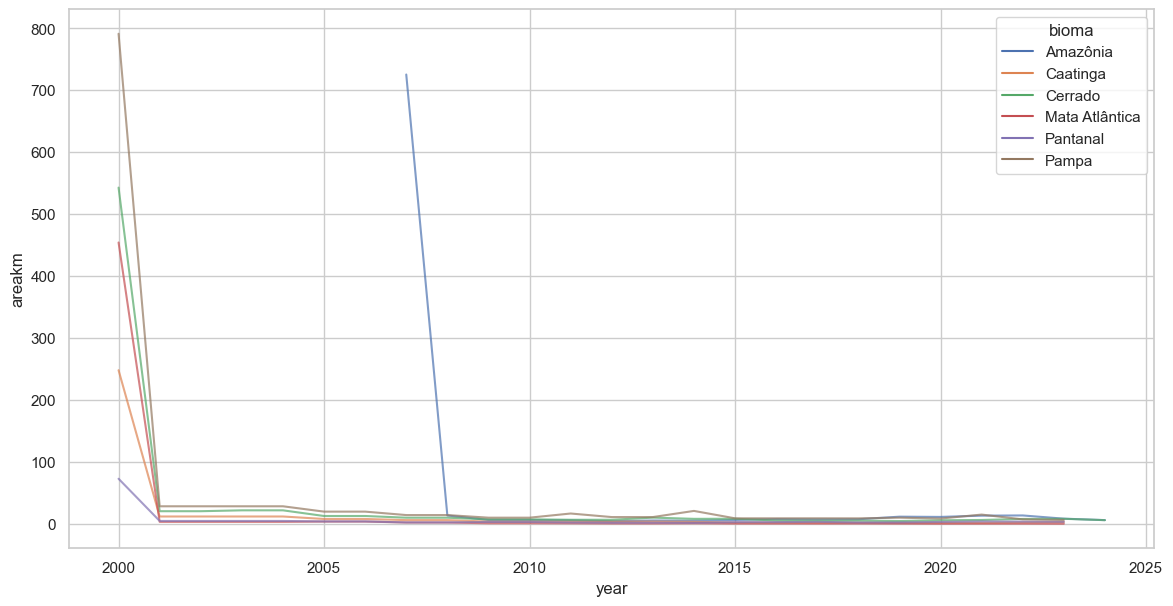

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Linha com desmatamento por bioma e ano (média por estado agrupada)
sns.lineplot(
    data=df_outliers_biomas,
    x="year",
    y="areakm",
    hue="bioma",
    estimator='mean',  # Média por ano e bioma
    ci=None,           # Sem intervalo de confiança
    alpha=0.7
)

# Pontos para outliers
outliers = df_outliers_biomas[df_outliers_biomas["outlier"]]

plt.scatter(
    outliers["year"],
    outliers["areakm"],
    c=sns.color_palette(n_colors=len(outliers["bioma"].unique())),
    s=80,
    edgecolor='black',
    label='Outliers',
    alpha=0.9
)

plt.title("Desmatamento anual por bioma com destaque para outliers")
plt.xlabel("Ano")
plt.ylabel("Área desmatada (km²)")
plt.legend(title="Bioma")
plt.tight_layout()
plt.show()


<h4>Outliers</h4>
Os outliers acentuados observados no ano 2000 foram considerados como o incremento acumulado de desmatamento até o início do monitoramento. Esse comportamento pode ser atribuído ao fato de que o monitoramento anual por satélite para esses biomas teve início justamente em 2000.

Para garantir a coerência nas comparações entre biomas, os anos iniciais do monitoramento, que apresentam padrões discrepantes, foram desconsiderados nas análises subsequentes.


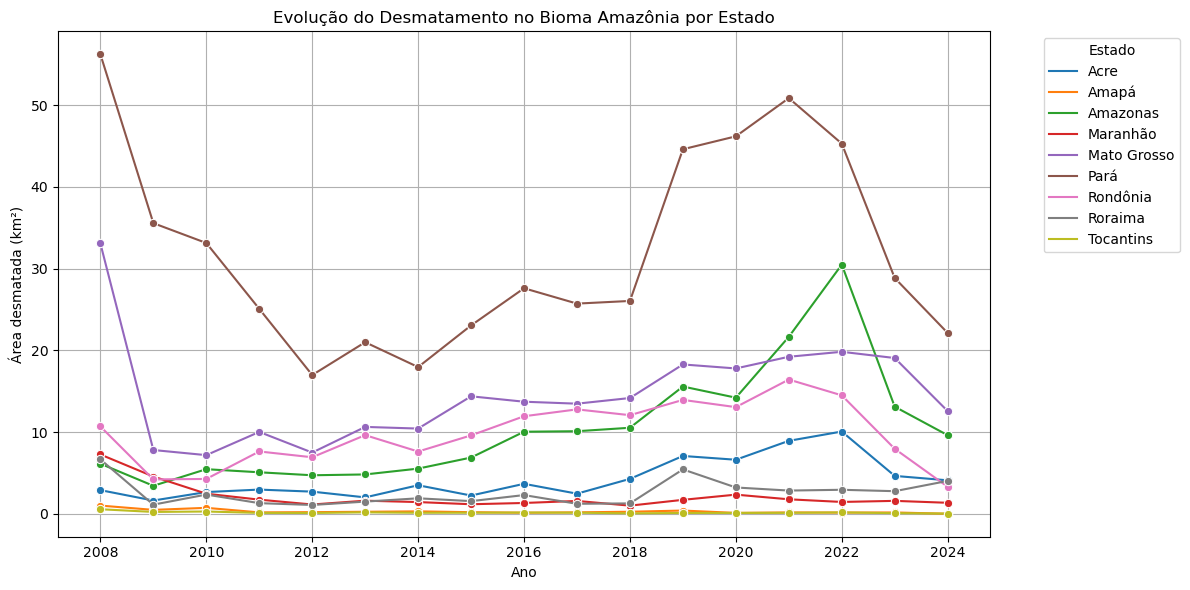

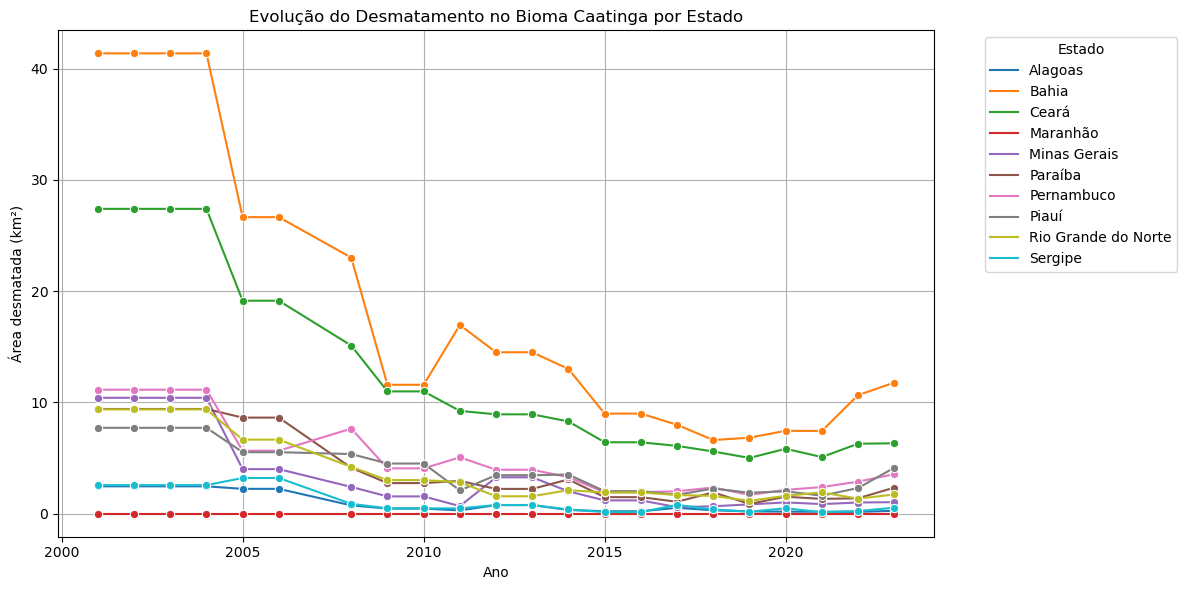

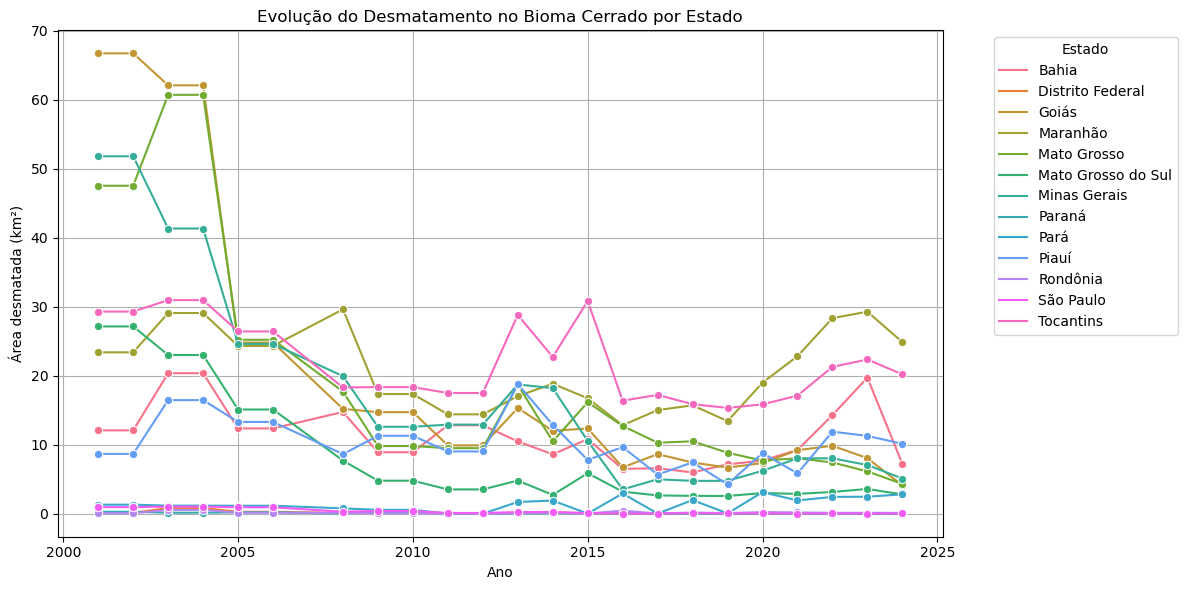

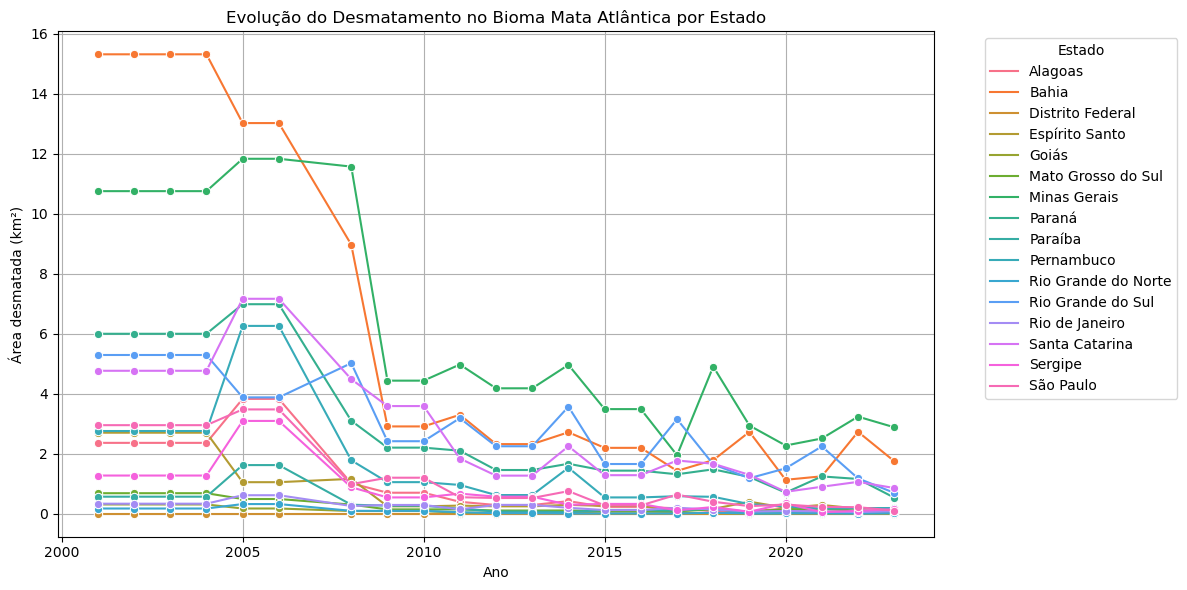

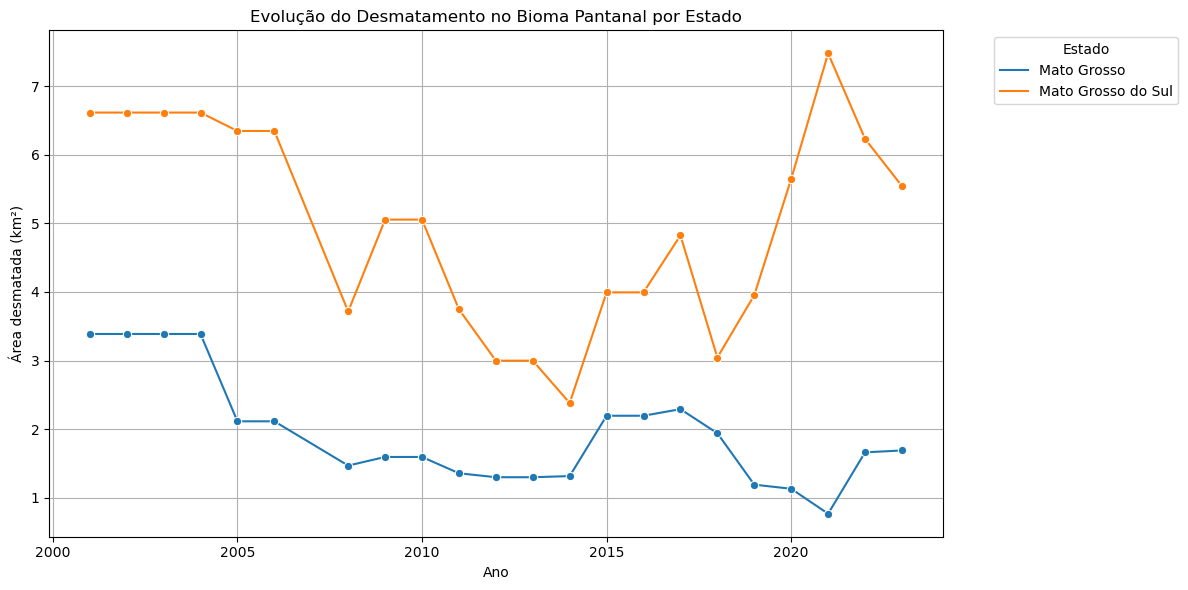

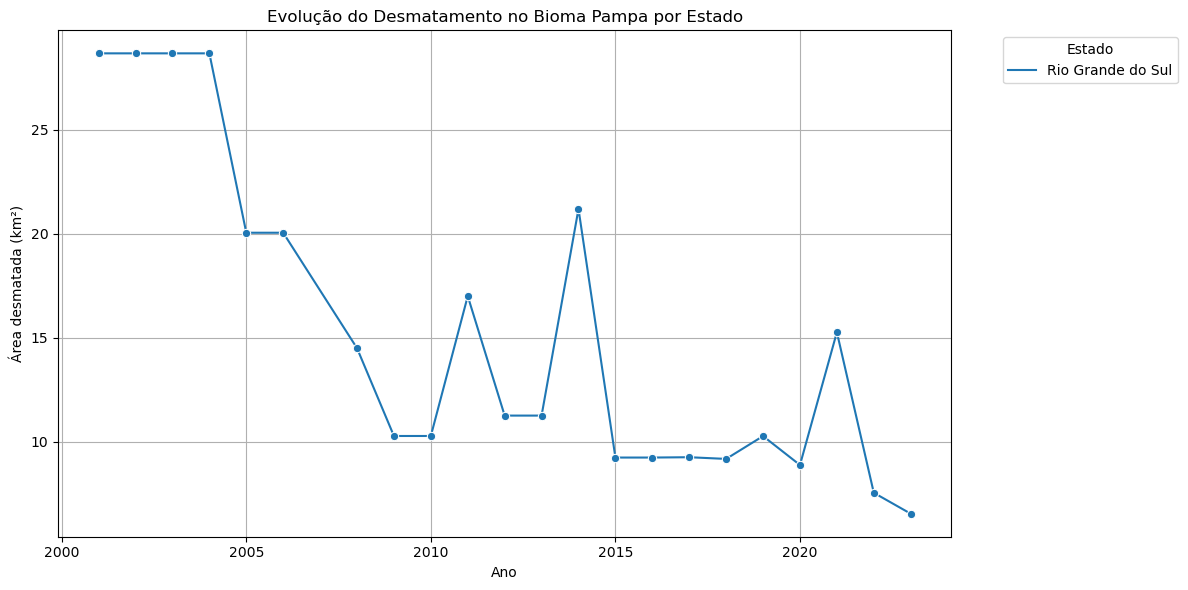

In [16]:
# Filtra os dados para o bioma desejado, ex: "Cerrado"
for i in biomas:
    df_bioma = d_biomas[d_biomas["bioma"] == i]
    
    if(i == 'Amazonia'):
        d_biomas = d_biomas[~d_biomas['year'].isin([2007, 2007.5])]
    else:
        d_biomas = d_biomas[~d_biomas['year'].isin([2000])]
    # Agrupa por estado e ano, somando a área
    df_agrupado = df_bioma.groupby(["state", "year"])["areakm"].sum().reset_index()
    
    # Gráfico
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_agrupado, x="year", y="areakm", hue="state", marker="o")
    
    plt.title(f"Evolução do Desmatamento no Bioma {i} por Estado")
    plt.xlabel("Ano")
    plt.ylabel("Área desmatada (km²)")
    plt.legend(title="Estado", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

<b>Estados com maior incremento de desmatamento</b>

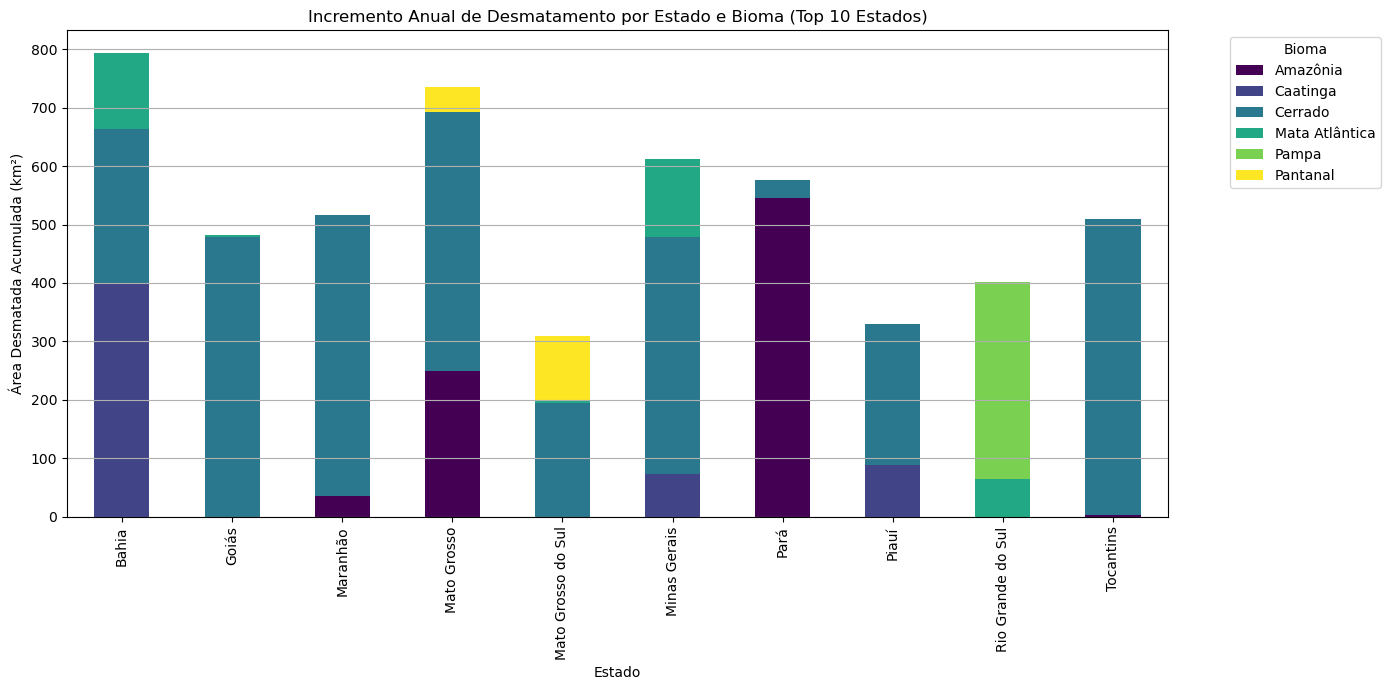

In [17]:
df_grouped = df_outliers_biomas.groupby(['state', 'bioma'])['areakm'].sum().reset_index()

top_states = df_grouped.groupby('state')['areakm'].sum().nlargest(10).index

# Filtra os dados apenas para os top 10 estados
df_top_states = df_grouped[df_grouped['state'].isin(top_states)]

# Transforma para formato adequado ao gráfico
df_pivot = df_top_states.pivot(index='state', columns='bioma', values='areakm').fillna(0)

# Gráfico de barras empilhadas
df_pivot.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')

plt.title('Incremento Anual de Desmatamento por Estado e Bioma (Top 10 Estados)')
plt.xlabel('Estado')
plt.ylabel('Área Desmatada Acumulada (km²)')
plt.legend(title='Bioma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<h1>Dados das Unidades de Conservação</h1>
As Unidades de Conservação (UCs) são entidades únicas, sob a gestão de um único órgão e administradas por uma única esfera federativa. No entanto, uma mesma UC pode abranger o território de mais de um município, bem como estar localizada em áreas que pertencem a diferentes biomas.

<h4>Inconsistência 1</h4>
Uso indevido de dados numéricos como categórico,usoo do ponto final para representar milha e uso de caracteres especiais para representar porcentagemr


In [57]:
areas_n_num = cnuc[['ID_UC','Área soma biomas', 'Área soma Biomas Continental', 'Área Ato Legal de Criação', '% Além da linha de costa']].copy()
areas_n_num

,ID_UC,Área soma biomas,Área soma Biomas Continental,Área Ato Legal de Criação,% Além da linha de costa
0,1,4.437,1.877,3.000,"57,7%"
1,2,143.356,143.356,143.866,"0,0%"
2,3,41.784,41.784,41.784,"0,0%"
3,4,82.681,82.681,0,"0,0%"
4,5,150.375,150.375,150.700,"0,0%"
...,...,...,...,...,...
3180,4.455,116,116,116,"0,0%"
3181,4.678,36,36,36,"0,0%"
3182,4.708,3.079,3.079,3.079,"0,0%"
3183,4.813,30,30,30,"0,0%"


In [58]:
for col in ['Área soma biomas', 'Área soma Biomas Continental', 'Área Ato Legal de Criação']:
    areas_n_num[col] = (
        areas_n_num[col]
        .astype(str)
        .str.replace('.', '', regex=False)  # remove ponto separador de milhar
        .str.replace(',', '.', regex=False) # troca vírgula decimal por ponto
    )
    areas_n_num[col] = pd.to_numeric(areas_n_num[col], errors='coerce')

areas_n_num['% Além da linha de costa'] = (
    areas_n_num['% Além da linha de costa']
    .astype(str)
    .str.replace('%', '', regex=False)  # remove %
    .str.replace(',', '.', regex=False) # vírgula para ponto decimal
)

areas_n_num['% Além da linha de costa'] = pd.to_numeric(areas_n_num['% Além da linha de costa'], errors='coerce') / 100

In [22]:
colunas = [
    'Área soma biomas',
    'Área soma Biomas Continental',
    'Área Ato Legal de Criação',
    '% Além da linha de costa'
]

# Cria uma coluna de outlier para cada variável numérica
for col in colunas:
    valores_validos = areas_n_num.loc[areas_n_num[col] != 0, col]
    media = valores_validos.mean()
    desvio = valores_validos.std()
    limite_inferior = media - 2 * desvio
    limite_superior = media + 2 * desvio
    nome_col_outlier = f'outlier_{col}'
    areas_n_num[nome_col_outlier] = (
        (areas_n_num[col] < limite_inferior) | (areas_n_num[col] > limite_superior)
    )
    print(col, " tem ",  areas_n_num[nome_col_outlier].sum(), "outliers de ", (areas_n_num[col] != 0).sum(), "tuplas com valores diferentes de zero")



Área soma biomas  tem  17 outliers de  3185 tuplas com valores diferentes de zero
Área soma Biomas Continental  tem  77 outliers de  3169 tuplas com valores diferentes de zero
Área Ato Legal de Criação  tem  15 outliers de  3136 tuplas com valores diferentes de zero
% Além da linha de costa  tem  0 outliers de  216 tuplas com valores diferentes de zero


A análise identificou poucos valores discrepantes nas variáveis numéricas relacionadas à área, mesmo após excluir os zeros, que representam casos especiais ou ausentes.

In [23]:
area_bioma = cnuc[['ID_UC','Código UC','Esfera Administrativa','Área soma biomas', 'Bioma declarado','Área soma Biomas Continental']].copy()
area_bioma['outlier_area_bioma'] = areas_n_num['outlier_Área soma biomas']
area_bioma['outlier_area_continental'] = areas_n_num['Área soma Biomas Continental']

print("Bioma de Área soma biomas que são outlier:\n",area_bioma[area_bioma['outlier_area_bioma'] == True].groupby('Bioma declarado').size().sort_values(ascending=False))
print("\nBioma de Área soma biomas Continental que são outlier:\n",area_bioma[area_bioma['outlier_area_continental'] == True].groupby('Bioma declarado').size().sort_values(ascending=False))

Bioma de Área soma biomas que são outlier:
 Bioma declarado
Amazônia        12
Área Marinha     5
dtype: int64

Bioma de Área soma biomas Continental que são outlier:
 Bioma declarado
Mata Atlântica    24
Cerrado            3
Amazônia           1
Caatinga           1
Pampa              1
Área Marinha       1
dtype: int64


A presença de outliers está associada à natureza dos biomas e à escala das UCs, e não necessariamente indica erro ou anomalia.

Biomas com maior extensão territorial e menor fragmentação tendem a concentrar os maiores valores de área.

<H4>Inconsistência 2</H4>
Dois atributos como potenciais chaves     

In [24]:
# Quantidade de valores únicos
print(f"ID_UC únicos: {cnuc['ID_UC'].nunique()}")
print(f"Código UC únicos: {cnuc['Código UC'].nunique()}")

ID_UC únicos: 3185
Código UC únicos: 3185


In [33]:
# Remove os pontos
id_uc['ID_UC_re'] = id_uc['ID_UC'].str.replace('.', '', regex=False)
id_uc['Codigo_UC_re'] = id_uc['Código UC'].str.replace('.', '', regex=False)

# Verifica se ID_UC está contido em Código UC, linha a linha
id_uc['contem'] = id_uc.apply(lambda row: row['ID_UC_re'] in row['Codigo_UC_re'], axis=1)

# Resultado
print("Quantidade de Códigos UC que tem ID UC como substring: ",id_uc['contem'].sum()) 

Quantidade de Códigos UC que tem ID UC como substring:  3185


<b> Hipótese: </b>
O campo ID_UC compõe parte do Código UC, mas ambos não são chaves primárias. O ID_UC é incrementado a cada nova inserção, sendo, portanto, crescente e sequencial. Já o Código UC tem parte de sua estrutura definida a partir do ID_UC, mas trata-se apenas de um identificador, que não deve ser tratado como valor numérico.

In [27]:
id_uc['ID_UC_re'] = pd.to_numeric(id_uc['ID_UC_re'], errors='coerce')
id_uc['ano_cria'] = cnuc['Ano de Criação'].copy()
id_uc['rect_ato'] = cnuc['Ano do ato legal mais recente'].copy()

print("Maior ID UC:",id_uc['ID_UC_re'].max())

Maior ID UC: 5055


In [28]:
print("Correlação entre o ID UC e o ano de criação:",  id_uc[['ano_cria', 'ID_UC_re']].corr().iloc[0, 1])
print("Correlação entre o ID UC e o ato legal mais recente:",  id_uc[['rect_ato', 'ID_UC_re']].corr().iloc[0, 1])

Correlação entre o ID UC e o ano de criação: 0.6931544598902324
Correlação entre o ID UC e o ato legal mais recente: 0.7394185051780178


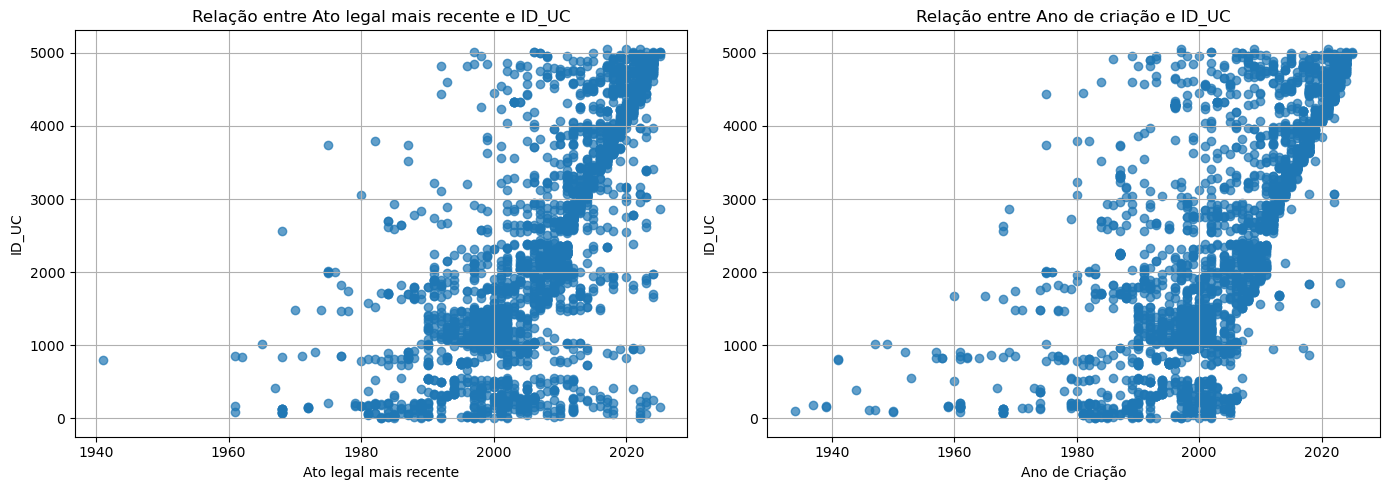

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].scatter(id_uc['rect_ato'], id_uc['ID_UC_re'], alpha=0.7)
axs[0].set_title('Relação entre Ato legal mais recente e ID_UC')
axs[0].set_xlabel('Ato legal mais recente')
axs[0].set_ylabel('ID_UC')
axs[0].grid(True)

axs[1].scatter(id_uc['ano_cria'], id_uc['ID_UC_re'], alpha=0.7)
axs[1].set_title('Relação entre Ano de criação e ID_UC')
axs[1].set_xlabel('Ano de Criação')
axs[1].set_ylabel('ID_UC')
axs[1].grid(True)

plt.tight_layout()
plt.show()

À medida que o tempo avança (em relação ao ano de criação ou de atos legais mais recentes), o valor do ID_UC tende a aumentar também;
Isso mostra que o ID_UC foi provavelmente atribuído de forma sequencial ao longo do tempo, como um identificador incremental.
Deste modo, ID UC e Código UC são chaves compostas. Ambas não tem postencial para se tornarrem variaveis numéricas.

<h1>Análise Exploratória</h1>
Após preparação dos dados os dados foram organizados da seguinte maneira:

In [37]:
from IPython.display import Markdown


sql_code = """
CREATE TABLE gestor (
    codigo_gestor TEXT PRIMARY KEY
);

CREATE TABLE bioma (
    bioma VARCHAR PRIMARY KEY
);

CREATE TABLE esfera_administrativa (
    esfera_administrativa VARCHAR PRIMARY KEY
);

CREATE TABLE uc (
    codigo_uc VARCHAR PRIMARY KEY,
    id_uc INTEGER UNIQUE NOT NULL,
    nome_uc TEXT NOT NULL,
    informacoes_gerais TEXT,
    esfera_administrativa VARCHAR REFERENCES esfera_administrativa(esfera_administrativa),
    categoria_manejo VARCHAR,
    categoria_iucn VARCHAR,
    uf CHAR(2),
    ano_criacao INTEGER,
    ano_ato_legal INTEGER,
    ato_legal_criacao TEXT,
    outros_atos_legais TEXT,
    plano_manejo INTEGER,
    conselho_gestor INTEGER,
    codigo_gestor VARCHAR REFERENCES gestor(codigo_gestor) ON DELETE SET NULL,
    orgao_gestor INTEGER,
    fonte_area INTEGER,
    area_soma_biomas DECIMAL(14,6),
    area_soma_biomas_continental DECIMAL(14,6),
    area_ato_legal DECIMAL(14,6),
    bioma_area DECIMAL(14,6),
    percentual_alem_linha_costa DECIMAL(5,2),
    grupo VARCHAR,
    pi INTEGER,
    us INTEGER,
    recortes_ha DECIMAL(14,6),
    mar_territorial INTEGER,
    municipio_costeiro INTEGER,
    municipio_costeiro_area_marinha INTEGER,
    programa_projeto TEXT,
    sitios_patrimonio_mundial TEXT,
    sitios_ramsar TEXT,
    mosaico TEXT,
    reserva_biosfera TEXT,
    qualidade_dados_georreferenciados TEXT,
    codigo_wdpa VARCHAR,
    data_publicacao_cnuc TIMESTAMP,
    data_certificacao_gestor DATE
);


CREATE TABLE uc_bioma (
    codigo_uc INTEGER NOT NULL REFERENCES uc(codigo_uc) ON DELETE CASCADE,
    bioma VARCHAR NOT NULL REFERENCES bioma(bioma) ON DELETE CASCADE,
    area_ha DECIMAL(14,6),
    PRIMARY KEY (codigo_uc, bioma)
);

CREATE TABLE municipios (
    municipio VARCHAR NOT NULL,
    uf VARCHAR NOT NULL,
    PRIMARY KEY (municipio, uf)
);

CREATE TABLE municipio_bioma (
    municipio VARCHAR NOT NULL,
    uf VARCHAR NOT NULL,
    bioma VARCHAR NOT NULL REFERENCES bioma(bioma) ON DELETE CASCADE,
    PRIMARY KEY (municipio, uf, bioma),
    FOREIGN KEY (municipio, uf) REFERENCES municipios(municipio, uf) ON DELETE CASCADE
);

CREATE TABLE desmatamento (
    ano INTEGER NOT NULL,
    municipio VARCHAR NOT NULL,
    uf VARCHAR NOT NULL,
    bioma VARCHAR NOT NULL,
	cod_ibge INTEGER UNIQUE,
    area_km2 FLOAT,
    PRIMARY KEY (ano, municipio, uf, bioma),
    FOREIGN KEY (municipio, uf, bioma) REFERENCES municipio_bioma(municipio, uf, bioma) ON DELETE CASCADE
);

CREATE TABLE municipios_abrangidos (
    codigo_uc INTEGER NOT NULL REFERENCES uc(codigo_uc) ON DELETE CASCADE,
    municipio VARCHAR NOT NULL,
    uf VARCHAR NOT NULL,
    PRIMARY KEY (codigo_uc, municipio, uf, bioma),
    FOREIGN KEY (municipio, uf, bioma) REFERENCES municipio_bioma(municipio, uf, bioma) ON DELETE CASCADE
);

-- Consulta 

WITH desmatamento_filtrado AS (
    SELECT
        d.*,
        uc.codigo_uc,
        uc.ano_criacao
    FROM desmatamento d
    JOIN municipios_abrangidos ma
        ON d.municipio = ma.municipio AND d.uf = ma.uf
    JOIN uc ON ma.codigo_uc = uc.codigo_uc
    WHERE d.ano > 2000
      AND uc.ano_criacao > 2001
),

anos_finais AS (
    SELECT
        d.municipio,
        d.uf,
        MAX(d.ano) AS ano_fim_dados
    FROM desmatamento d
    GROUP BY d.municipio, d.uf
),

desmatamento_uc AS (
    SELECT
        df.codigo_uc,
        ma.municipio,
        ma.uf,
        mb.bioma,
        uc.ano_criacao,
        af.ano_fim_dados,

        SUM(CASE
            WHEN df.ano >= 2001 AND df.ano < df.ano_criacao THEN df.area_km2
            ELSE 0
        END) AS desmatamento_antes,

        SUM(CASE
            WHEN df.ano >= df.ano_criacao THEN df.area_km2
            ELSE 0
        END) AS desmatamento_depois
    FROM desmatamento_filtrado df
    JOIN municipios_abrangidos ma
        ON df.codigo_uc = ma.codigo_uc
    JOIN municipio_bioma mb
        ON ma.municipio = mb.municipio AND ma.uf = mb.uf
    JOIN uc ON df.codigo_uc = uc.codigo_uc
    JOIN anos_finais af
        ON ma.municipio = af.municipio AND ma.uf = af.uf
    GROUP BY df.codigo_uc, ma.municipio, ma.uf, mb.bioma, uc.ano_criacao, af.ano_fim_dados
)

SELECT
    uc.nome_uc,
    du.ano_criacao,
    du.ano_fim_dados - du.ano_criacao AS tempo_uc,
    du.municipio,
    du.uf,
    du.bioma,
    du.desmatamento_antes,
    du.desmatamento_depois
FROM desmatamento_uc du
JOIN uc ON du.codigo_uc = uc.codigo_uc
ORDER BY du.municipio, du.uf;


"""

display(Markdown(f"```sql\n{sql_code}\n```"))

```sql

CREATE TABLE gestor (
    codigo_gestor TEXT PRIMARY KEY
);

CREATE TABLE bioma (
    bioma VARCHAR PRIMARY KEY
);

CREATE TABLE esfera_administrativa (
    esfera_administrativa VARCHAR PRIMARY KEY
);

CREATE TABLE uc (
    codigo_uc VARCHAR PRIMARY KEY,
    id_uc INTEGER UNIQUE NOT NULL,
    nome_uc TEXT NOT NULL,
    informacoes_gerais TEXT,
    esfera_administrativa VARCHAR REFERENCES esfera_administrativa(esfera_administrativa),
    categoria_manejo VARCHAR,
    categoria_iucn VARCHAR,
    uf CHAR(2),
    ano_criacao INTEGER,
    ano_ato_legal INTEGER,
    ato_legal_criacao TEXT,
    outros_atos_legais TEXT,
    plano_manejo INTEGER,
    conselho_gestor INTEGER,
    codigo_gestor VARCHAR REFERENCES gestor(codigo_gestor) ON DELETE SET NULL,
    orgao_gestor INTEGER,
    fonte_area INTEGER,
    area_soma_biomas DECIMAL(14,6),
    area_soma_biomas_continental DECIMAL(14,6),
    area_ato_legal DECIMAL(14,6),
    bioma_area DECIMAL(14,6),
    percentual_alem_linha_costa DECIMAL(5,2),
    grupo VARCHAR,
    pi INTEGER,
    us INTEGER,
    recortes_ha DECIMAL(14,6),
    mar_territorial INTEGER,
    municipio_costeiro INTEGER,
    municipio_costeiro_area_marinha INTEGER,
    programa_projeto TEXT,
    sitios_patrimonio_mundial TEXT,
    sitios_ramsar TEXT,
    mosaico TEXT,
    reserva_biosfera TEXT,
    qualidade_dados_georreferenciados TEXT,
    codigo_wdpa VARCHAR,
    data_publicacao_cnuc TIMESTAMP,
    data_certificacao_gestor DATE
);


CREATE TABLE uc_bioma (
    codigo_uc INTEGER NOT NULL REFERENCES uc(codigo_uc) ON DELETE CASCADE,
    bioma VARCHAR NOT NULL REFERENCES bioma(bioma) ON DELETE CASCADE,
    area_ha DECIMAL(14,6),
    PRIMARY KEY (codigo_uc, bioma)
);

CREATE TABLE municipios (
    municipio VARCHAR NOT NULL,
    uf VARCHAR NOT NULL,
    PRIMARY KEY (municipio, uf)
);

CREATE TABLE municipio_bioma (
    municipio VARCHAR NOT NULL,
    uf VARCHAR NOT NULL,
    bioma VARCHAR NOT NULL REFERENCES bioma(bioma) ON DELETE CASCADE,
    PRIMARY KEY (municipio, uf, bioma),
    FOREIGN KEY (municipio, uf) REFERENCES municipios(municipio, uf) ON DELETE CASCADE
);

CREATE TABLE desmatamento (
    ano INTEGER NOT NULL,
    municipio VARCHAR NOT NULL,
    uf VARCHAR NOT NULL,
    bioma VARCHAR NOT NULL,
	cod_ibge INTEGER UNIQUE,
    area_km2 FLOAT,
    PRIMARY KEY (ano, municipio, uf, bioma),
    FOREIGN KEY (municipio, uf, bioma) REFERENCES municipio_bioma(municipio, uf, bioma) ON DELETE CASCADE
);

CREATE TABLE municipios_abrangidos (
    codigo_uc INTEGER NOT NULL REFERENCES uc(codigo_uc) ON DELETE CASCADE,
    municipio VARCHAR NOT NULL,
    uf VARCHAR NOT NULL,
    PRIMARY KEY (codigo_uc, municipio, uf, bioma),
    FOREIGN KEY (municipio, uf, bioma) REFERENCES municipio_bioma(municipio, uf, bioma) ON DELETE CASCADE
);

-- Consulta 

WITH desmatamento_filtrado AS (
    SELECT
        d.*,
        uc.codigo_uc,
        uc.ano_criacao
    FROM desmatamento d
    JOIN municipios_abrangidos ma
        ON d.municipio = ma.municipio AND d.uf = ma.uf
    JOIN uc ON ma.codigo_uc = uc.codigo_uc
    WHERE d.ano > 2000
      AND uc.ano_criacao > 2001
),

anos_finais AS (
    SELECT
        d.municipio,
        d.uf,
        MAX(d.ano) AS ano_fim_dados
    FROM desmatamento d
    GROUP BY d.municipio, d.uf
),

desmatamento_uc AS (
    SELECT
        df.codigo_uc,
        ma.municipio,
        ma.uf,
        mb.bioma,
        uc.ano_criacao,
        af.ano_fim_dados,

        SUM(CASE
            WHEN df.ano >= 2001 AND df.ano < df.ano_criacao THEN df.area_km2
            ELSE 0
        END) AS desmatamento_antes,

        SUM(CASE
            WHEN df.ano >= df.ano_criacao THEN df.area_km2
            ELSE 0
        END) AS desmatamento_depois
    FROM desmatamento_filtrado df
    JOIN municipios_abrangidos ma
        ON df.codigo_uc = ma.codigo_uc
    JOIN municipio_bioma mb
        ON ma.municipio = mb.municipio AND ma.uf = mb.uf
    JOIN uc ON df.codigo_uc = uc.codigo_uc
    JOIN anos_finais af
        ON ma.municipio = af.municipio AND ma.uf = af.uf
    GROUP BY df.codigo_uc, ma.municipio, ma.uf, mb.bioma, uc.ano_criacao, af.ano_fim_dados
)

SELECT
    uc.nome_uc,
    du.ano_criacao,
    du.ano_fim_dados - du.ano_criacao AS tempo_uc,
    du.municipio,
    du.uf,
    du.bioma,
    du.desmatamento_antes,
    du.desmatamento_depois
FROM desmatamento_uc du
JOIN uc ON du.codigo_uc = uc.codigo_uc
ORDER BY du.municipio, du.uf;



```

In [31]:
df_nulo_uc = pd.read_csv("nulos-uc.csv", quotechar='"')
df_nulo_ds = pd.read_csv("nulos-desmt.csv", quotechar='"')
print("Atributos nulos na tabela Unidades de Conservação:\n", df_nulo_uc)
print("Atributos nulos na tabela Incremento Desmatamento:\n", df_nulo_uc)

Atributos nulos na tabela Unidades de Conservação:
                                coluna  nulos
0                               id_uc      0
1                           codigo_uc      0
2            data_certificacao_gestor      0
3                data_publicacao_cnuc      0
4                         codigo_wdpa      0
5   qualidade_dados_georreferenciados      0
6                    reserva_biosfera   1002
7                             mosaico   2969
8                       sitios_ramsar   3112
9           sitios_patrimonio_mundial   3143
10                   programa_projeto   2992
11    municipio_costeiro_area_marinha      0
12                 municipio_costeiro      0
13                    mar_territorial      0
14                        recortes_ha   3185
15                                 us      0
16                                 pi      0
17                              grupo      0
18        percentual_alem_linha_costa      0
19                         bioma_area   3185
20 

Após a análise exploratória realizada no PostgreSQL com SQL, observou-se que a <b>tabela de incremento de desmatamento está bem estruturada</b>, sem a presença de valores nulos. Em contrapartida, a <b>tabela referente às Unidades de Conservação (UCs) apresentou diversas inconsistências</b>, incluindo variáveis com altos índices de valores ausentes e áreas registradas com valor zero. Além disso, foram identificados erros de formatação nos dados numéricos, como o uso indevido de ponto para separação de milhar e vírgula como separador decimal. Essas inconsistências foram corrigidas ao longo do processo de desenvolvimento e limpeza do banco de dados.

<h1>Correlações</h1>

Para compreender a evolução do desmatamento ao longo do tempo e avaliar a eficácia de estratégias de proteção e gestão territorial. A análise será focada na busca de padrões temporais de desmatamento, comparando períodos anteriores e posteriores a criação de Unidades de Conservação por municipio, de modo a identificar tendências e impactos.

In [139]:
juncao = pd.read_csv('juncao.csv')
juncao

,codigo_uc,nome_uc,ano_criacao,tempo_uc,municipio,uf,bioma,desmatamento_antes,desmatamento_depois
0,0000.00.2123,RESERVA PARTICULAR DO PATRIMÔNIO NATURAL PICO ...,2010,13,ABAÍRA,BA,Caatinga,0.133555,0.090093
1,0000.00.0261,ESTAÇÃO ECOLÓGICA DA MATA PRETA,2005,18,ABELARDO LUZ,SC,Mata Atlântica,2.080774,3.017166
2,0000.26.1928,ÁREA DE PROTEÇÃO AMBIENTAL ALDEIA-BEBERIBE,2010,13,ABREU E LIMA,PE,Mata Atlântica,3.754277,0.444442
3,0000.22.4808,ÁREA DE PROTEÇÃO AMBIENTAL DAS NASCENTES DO RI...,2017,6,ACAUÃ,PI,Caatinga,2.032347,0.356605
4,0134.52.3062,ÁREA DE PROTEÇÃO AMBIENTAL DOS BURITIS,2022,2,ACREÚNA,GO,Cerrado,1.398343,0.010851
...,...,...,...,...,...,...,...,...,...
3073,0000.33.3549,REFÚGIO DE VIDA SILVESTRE ESTADUAL DO MÉDIO PA...,2016,7,VOLTA REDONDA,RJ,Mata Atlântica,0.682050,0.120676
3074,6305.33.4672,PARQUE NATURAL MUNICIPAL VOLTA REDONDA,2021,2,VOLTA REDONDA,RJ,Mata Atlântica,0.009141,0.000000
3075,6305.33.4957,REFÚGIO DE VIDA SILVESTRE VALE DOS PURIS,2019,4,VOLTA REDONDA,RJ,Mata Atlântica,0.009020,0.000121
3076,0000.29.0301,ÁREA DE PROTEÇÃO AMBIENTAL CAMINHOS ECOLÓGICOS...,2003,20,WENCESLAU GUIMARÃES,BA,Mata Atlântica,0.124993,2.282827


In [143]:
filtro = (juncao['desmatamento_antes'] > 0) & (juncao['desmatamento_depois'] > 0)
juncao = juncao.loc[filtro].copy()
juncao['desmatM_ano_antes'] = juncao['desmatamento_antes'] / (juncao['ano_criacao'] - 2001)
juncao['desmatM_ano_depois'] = juncao['desmatamento_depois'] / (juncao['tempo_uc'])
juncao['variacM_desmt'] = juncao['desmatM_ano_antes'] - juncao['desmatM_ano_depois']
juncao['variac_desmt'] = juncao['desmatamento_antes'] - juncao['desmatamento_depois']

<h4>Bioma, municipio e desmatamento</h4>

In [144]:
# Filtra dados válidos
df_validos = juncao[juncao['variacM_desmt'].notna()]
df_validos = df_validos[df_validos['bioma'] != 'Área Marinha']

# Calcula mediana da variação por bioma
mediana_variacao = df_validos.groupby('bioma')['variacM_desmt'].median().reset_index(name='mediana_variacao_normalizada')

# Conta o número de municípios por bioma
contagem_municipios = df_validos.groupby('bioma').size().reset_index(name='n_municipios')

# Junta os dois dataframes pelo bioma
variacao_bioma = mediana_variacao.merge(contagem_municipios, on='bioma')

# Calcula a divisão mediana / número de municípios
variacao_bioma['mediana_dividida_por_n'] = variacao_bioma['mediana_variacao_normalizada'] / variacao_bioma['n_municipios']

variacao_bioma


,bioma,mediana_variacao_normalizada,n_municipios,mediana_dividida_por_n
0,Amazônia,0.730289,143,0.005107
1,Caatinga,0.066204,321,0.000206
2,Cerrado,0.089730,510,0.000176
3,Mata Atlântica,0.006151,1522,0.000004
4,Pampa,0.030299,28,0.001082
5,Pantanal,-0.094811,40,-0.002370


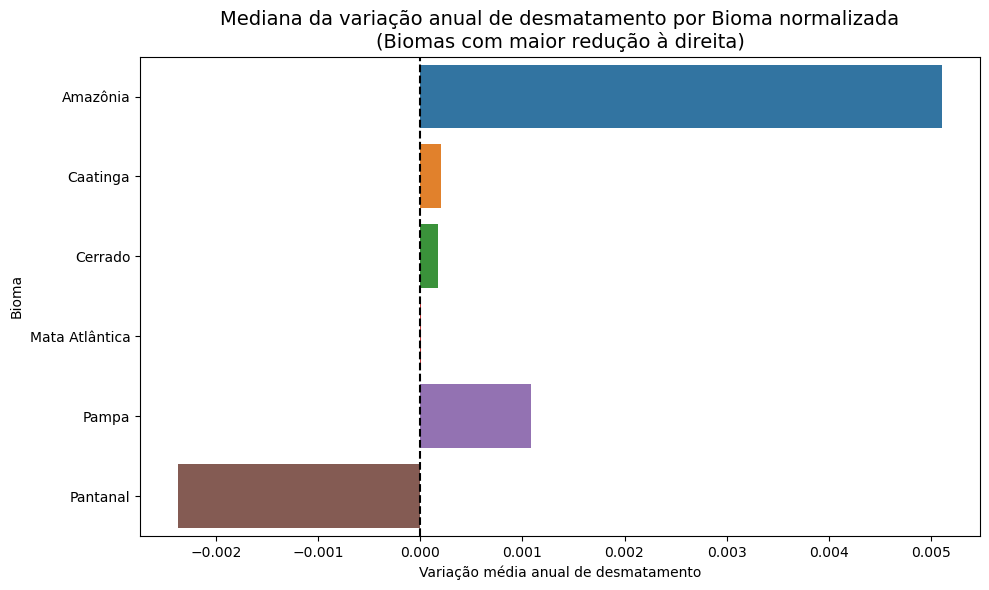

In [145]:

# Define o tamanho da figura
plt.figure(figsize=(10, 6))

# Cria o gráfico de barras
sns.barplot(data=variacao_bioma, x='mediana_dividida_por_n', y='bioma')

# Títulos e rótulos
plt.title('Mediana da variação anual de desmatamento por Bioma normalizada\n(Biomas com maior redução à direita)', fontsize=14)
plt.xlabel('Variação média anual de desmatamento')
plt.ylabel('Bioma')

# Linha vertical no zero para referência
plt.axvline(x=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()


<b>Conclusão: </b>A efetividade das UCs varia entre biomas sendo a Amazônia e o Pantanal os biomas com as maiores reduções proporcionais no desmatamento médio anual após a criação das UCs. Já Mata Atlântica, Cerrado e Pantanal mostraram menor efeito positivo, indicando variações na efetividade das UCs entre os biomas. O Pampa o tem a menor reduçaõ entre os biomas o que pode indicar baixa efetividade das UCs.

<h4>Tempo de criação de UCs e desmatamento</h4>

In [146]:
juncao_muni = juncao.groupby('municipio', as_index=False)['variacM_desmt'].sum()

variancia_media_positiva = (juncao_muni['variacM_desmt'] > 0).sum()
variancia_media_negativa = (juncao_muni['variacM_desmt'] <= 0).sum()
total_municipios = juncao_muni.shape[0]

# Proporções
proporcao_positiva = (variancia_media_positiva / total_municipios) 
proporcao_negativa = (variancia_media_negativa / total_municipios) 

print(f"Proporção de municípios que obtiveram redução no incremento médio de desmatamento por ano após criação das UCs: {proporcao_positiva:.2f}%")
print(f"Proporção de municípios que obtiveram aumento no incremento médio de desmatamento por ano após criação das UCs: {proporcao_negativa:.2f}%")

Proporção de municípios que obtiveram redução no incremento médio de desmatamento por ano após criação das UCs: 0.89%
Proporção de municípios que obtiveram aumento no incremento médio de desmatamento por ano após criação das UCs: 0.10%


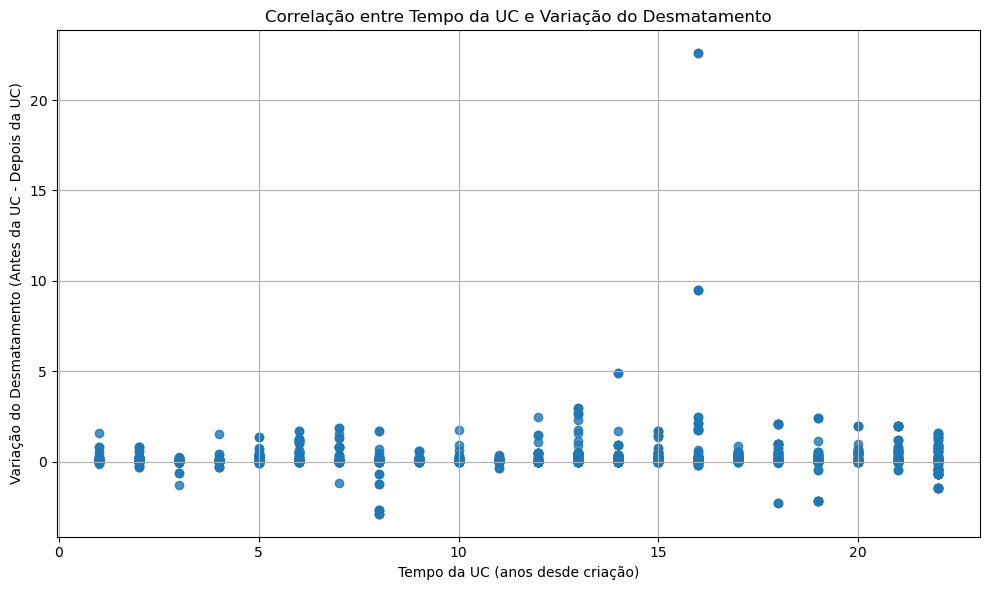

In [148]:
# Plotando o gráfico de dispersão com linha de tendência
plt.figure(figsize=(10, 6))
sns.regplot(data=juncao, x='tempo_uc', y='variacM_desmt', ci=None)
plt.title('Correlação entre Tempo da UC e Variação do Desmatamento')
plt.xlabel('Tempo da UC (anos desde criação)')
plt.ylabel('Variação do Desmatamento (Antes da UC - Depois da UC)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [149]:
# Supondo que você já tenha a coluna 'tempo_uc' (tempo desde criação até ano max)
df_uc = juncao[(juncao['variacM_desmt'].notna()) & (juncao['tempo_uc'].notna())]

correlacao_tempo = df_uc[['tempo_uc', 'variacM_desmt']].corr().iloc[0,1]
print(f'Correlação entre tempo da UC e variação do desmatamento: {correlacao_tempo:.4f}')

Correlação entre tempo da UC e variação do desmatamento: 0.0709


<b>Conclusão: </b> Unidades de Conservação mais velhas tende a ter maior variação média de desmatamento, mas como a correlaçaõ é bem baixa essa tendência é bem fraca.

<h1>Conclusão</h1>
A integração das diferentes bases de dados permitiu análises mais completas sobre desmatamento e conservação ambiental. A junção das tabelas enriqueceu as informações e revelou padrões por bioma e município, mostrando como a criação de Unidades de Conservação se relaciona com a redução ou aumento do desmatamento ao longo do tempo.
empo.


<h1>Principais Desafios:</h1>
<ul>
    <li>Dados desorganizados e inconsistentes</li>
    <li>Uso incorreto de pontuação nos arquivos de origem (ex.: vírgula como separador decimal e ponto como separador de milhar)</li>
    <li>Na tabela de Unidades de Conservação, identificaram-se diversas anomalias nos processos de inserção, atualização e remoção de dados, o que resultou em grande quantidade de valores nulos</li>
    <li>Necessidade de adaptação dos arquivos CSV para garantir compatibilidade com o banco de dados</li>
    <li>Grande número de atributos em algumas tabelas, dificultando a modelagem e análise</li>
</ul>


<h1>Bibliografia e Links Uteis:</h1>
<ul>
    <li>
        <b>Fonte dos dados das Unidades de Conservação: </b>
        <br> Portal de Dados Abertos MMA
        <i>(<a href="https://dados.mma.gov.br/dataset/unidadesdeconservacao">https://dados.mma.gov.br/dataset/unidadesdeconservacao</a>)</i>
    </li>
    <br>
    <li>
        <b>Dicionário de Dados: </b>
        <i>(<a href="https://dados.mma.gov.br/dataset/44b6dc8a-dc82-4a84-8d95-1b0da7c85dac/resource/71dc3c85-019f-4176-a43e-5aa41b3ec434/download/dicionario-de-dados-shapefile.pdf">https://dados.mma.gov.br/dataset/dicionariodedados</a>)</i>
    </li>
    <br>
    <li>
        <b>Paindel de Dados das Unidades de Conservação: </b>
        <i>(<a href="https://cnuc.mma.gov.br/powerbi">https://cnuc.mma.gov.br/powerbi</a>)</i>
    </li>
    <br>
    <li>
        <b>Fonte dos dados <i>tabulados</i> de Incremento de Desmatamento por Bioma: </b>
        <br> TerraBrasilis (painel interativo do INPE)
        <i>(<a href="https://terrabrasilis.dpi.inpe.br/app/dashboard/deforestation/biomes">
            https://terrabrasilis.dpi.inpe.br/app/dashboard/deforestation/biomes</a>)</i>
    </li>
    <br>
    <li>
        <b>Dados <i>originais</i> de Incremento na supressão da vegetação nativa por Bioma: </b>
        <br> <b> Fonte: </b> TerraBrasilis Catalogue <br>
        <ul>
            <li><b>Amazonia:</b> <i> <a href="https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/b75b83db-8026-43f9-9537-ee1dfa308158">
           https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/amazonia</a></i>
            </li>
            <li><b>Amazonia Legal:</b> <i> <a href="https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/a5220c18-f7fa-4e3e-b39b-feeb3ccc4830">
            https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/amazonialegal</a></i>
            </li>
            <li><b>Cerrado:</b> <i> <a href="https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/6b621182-93d6-4a83-b5db-ae53a621276d">
            https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/cerrado</a></i>
            </li>
            <li><b>Caatinga:</b> <i> <a href="https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/6f585e6e-dae3-4a5b-b74-7c24dedf67ed">
            https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/caating</a></i>
            </li>
            <li><b>Mata Atlântica:</b> <i> <a href="https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/2b439f5a-b53d-4d56-9937-99026a205e9e">
            https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/mataatlantica</a></i>
            </li>
            <li><b>Pantanal:</b> <i> <a href="https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/616943ab-a40f-4196-9592-ecc6a7c4901e">
            https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/pantanal</a></i>
            </li>
            <li><b>Pampa:</b> <i> <a href="https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/a551570c-78a2-45b3-95e8-0e518fbce941">
            https://terrabrasilis.dpi.inpe.br/geonetwork/srv/eng/catalog.search#/metadata/pampa</a></i>
            </li>
        </ul>
    </li>
</ul>